In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
import talib
import pickle
import pystan
import stan_utility

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:
# import multiprocessing
# multiprocessing.set_start_method("fork")

## Simulators

### Dynamic

In [7]:
def dynamic_prior(batch_size):
    """
    Generates a random draw from the diffusion model prior.
    """
    v = np.random.gamma(2.5, 1/1.5, (batch_size, 4))
    a = np.random.gamma(4.0, 1/3.0, batch_size)
    ndt = np.random.gamma(1.5, 1/5.0, batch_size)
    hyper_params = np.random.uniform(0.01, 0.1, (batch_size, 6))

    return np.c_[v, a, ndt, hyper_params]


@njit
def context_gen(batch_size, n_obs):
    obs_per_condition = int(n_obs / 4)
    context = np.zeros((batch_size, n_obs), dtype=np.int32)
    x = np.repeat([1, 2, 3, 4], obs_per_condition)
    for i in range(batch_size):
        np.random.shuffle(x)
        context[i] = x
    return context


@njit
def diffusion_trial(v, a, ndt, zr=0.5, dt=0.001, s=1.0, max_iter=1e4):
    """
    Simulates a single reaction time from a simple drift-diffusion process.
    """

    n_iter = 0
    x = a * zr
    c = np.sqrt(dt * s)
    
    while x > 0 and x < a:
        
        # DDM equation
        x += v*dt + c * np.random.randn()
        
        n_iter += 1
        
    rt = n_iter * dt
    return rt+ndt if x > 0 else -(rt+ndt)


@njit
def dynamic_diffusion_process(prior_samples, context, n_obs):
    """
    Performs one run of a dynamic diffusion model process.
    """
    
    params, params_stds = np.split(prior_samples, 2, axis=-1)
    params_t = params
    
    params_t_array = np.zeros((n_obs, params.shape[0]))
    
    # Draw first param combination from prior
    rt = np.zeros(n_obs)
    
    # Iterate over number of trials
    for t in range(n_obs):
        
        # Run diffusion process
        rt[t] = diffusion_trial(params_t[context[t] - 1], params_t[4], params_t[5])
        
        # Store before transition
        params_t_array[t] = params_t
        
        # Transition and ensure non-negative parameters
        params_t = params_t + params_stds * np.random.randn(params.shape[0])
        
        # Constraints
        params_t[0] = min(max(params_t[0], 0.0), 8)
        params_t[1] = min(max(params_t[1], 0.0), 8)
        params_t[2] = min(max(params_t[2], 0.0), 8)
        params_t[3] = min(max(params_t[3], 0.0), 8)
        params_t[4] = min(max(params_t[4], 0.0), 6)
        params_t[5] = min(max(params_t[5], 0.0), 4)
        
    return np.atleast_2d(rt).T, params_t_array, params_stds


@njit
def batch_simulator(prior_samples, context, n_obs):
    
    batch_size = prior_samples.shape[0]
    rt = np.zeros((batch_size, n_obs, 1))
    theta_d = np.zeros((batch_size, n_obs, 6))
    theta_s = np.zeros((batch_size, 6))
    
    for i in range(batch_size):
        rt[i], theta_d[i], theta_s[i] = dynamic_diffusion_process(prior_samples[i], 
                                                                  context[i],
                                                                  n_obs)
    
    return rt, theta_d, theta_s

### Static

In [8]:
@njit
def static_diffusion_process(prior_samples, context, n_obs):
    """
    Performs one run of a static diffusion model process.
    """
    
    params_t, params_stds = np.split(prior_samples, 2, axis=-1)
    
    rt = np.zeros(n_obs)
    
    # Iterate over number of trials
    for t in range(n_obs):
        
        # Run diffusion process
        rt[t] = diffusion_trial(params_t[context[t] - 1], params_t[4], params_t[5])
        
    return np.atleast_2d(rt).T, params_t
    

@njit
def static_batch_simulator(prior_samples, context, n_obs):
    
    batch_size = prior_samples.shape[0]
    rt = np.zeros((batch_size, n_obs, 1))
    theta = np.zeros((batch_size, n_obs, 6))

    for i in range(batch_size):
        rt[i], theta[i] = static_diffusion_process(prior_samples[i], 
                                                         context[i],
                                                         n_obs)
    return rt, theta

## Stan modeling

In [13]:
stan_model = """
data {
  int<lower=0> N;                 
  real<lower=0> rt[N];    
  int<lower=0,upper=1> correct[N];
  int<lower=1,upper=4> context[N];
}

parameters {
  real<lower=0> v[4];
  real<lower=0> a; 
  real<lower=0> ndt;
}

model {
  // Priors
  v ~ gamma(2.5, 1.5);
  a ~ gamma(4.0, 3.0);
  ndt ~ gamma(1.5, 5.0);
  
  for (n in 1:N) {
     if (correct[n] == 1) {
        rt[n] ~ wiener(a, ndt, 0.5, v[context[n]]);
     } 
     else {
        rt[n] ~ wiener(a, ndt, 1 - 0.5, -v[context[n]]);
     }
  }
}
"""

In [14]:
# # compile stan model
# sm = pystan.StanModel(model_code=stan_model)

In [15]:
def to_stan(sim_data):
    """
    Convert data from simulator to stan-friendly format.
    """
    rt = sim_data[:, 0]
    context = sim_data[:, 1].astype(np.int32)
    correct = (rt >= 0).astype(np.int32)
    rt = np.abs(rt).astype(np.float32)
    return {'rt': rt, 'correct': correct, 'context': context, 'N': rt.shape[0]}

def loop_stan(data, verbose=True):
    """
    Loop through data and obtain posteriors.
    """
    
    stan_post_samples = []
    for i in range(data.shape[0]):
        data_i = to_stan(data[i])
        ndt_init = data_i['rt'].min() * 0.75
        init = {'ndt': ndt_init}
        fit = sm.sampling(data=data_i, 
                          iter=2000, chains=4, n_jobs=4, init=[init, init, init, init],
                          control=dict(adapt_delta=0.99, max_treedepth=15))
        samples = fit.extract(permuted=True)
        stan_post_samples.append(samples)
        if verbose:
            print(f'Finished estimating data set {i + 1}...')
    return stan_post_samples

In [16]:
# N_OBS = 800
# batch_size = 100
# prior_draws = dynamic_prior(batch_size)
# context = context_gen(batch_size, N_OBS)
# sim_data, params_t = static_batch_simulator(prior_draws, context, N_OBS)
# stan_post_samples = loop_stan(sim_data)
# pickle.dump(stan_post_samples, open('./stan_posteriors_mine.pkl', 'wb+'))

# Amortizers

## Network architecture

In [20]:
class HeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            Dense(8, activation='selu', kernel_initializer='lecun_normal'),
            LSTM(512, return_sequences=True),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])
        
    def call(self, x):
        """
        Forward pass through the model.
        """
        
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic stuff
        preds_dyn = self.dynamic_predictor(rep)
     
        return preds_dyn

## Loss

In [21]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

## Epoch helper

In [22]:
def train_epoch(network, optimizer, batch_size, steps_per_epoch, p_bar):
    
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
        
            # Simulate from model
            prior_draws = dynamic_prior(batch_size)
            context = context_gen(batch_size, N_OBS)
            x_t, params_t, _= batch_simulator(prior_draws, context, N_OBS)
            net_in = tf.concat((x_t, context[:, :, np.newaxis]), axis=-1)
            pred_params_t = network(net_in)

            # Loss dynamic and static
            loss_d = nll(params_t, pred_params_t)
            
            total_loss = loss_d
            
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)

## Training

In [24]:
N_OBS = 800
batch_size = 32
epochs = 50
steps_per_epoch = 1000
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
network = HeteroscedasticNetwork(6)

In [15]:
# change learning rate
epochs = 20
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [25]:
for ep in range(1, epochs+1):
    with tqdm(total=steps_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        train_epoch(network, optimizer, batch_size, steps_per_epoch, p_bar)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

2022-02-09 12:21:20.769011: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-02-09 12:21:20.924012: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-02-09 12:21:20.942487: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55a32a87ca90
2022-02-09 12:26:52.868526: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 55.00MiB (rounded to 57671680)requested by op CudnnRNNBackprop
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-02-09 12:26:52.868718: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-02-09 12:26:52.868756: I tensorflow/core/common_runtime/bfc

InternalError: Failed to call ThenRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 8, 512, 1, 800, 32, 512]  [Op:CudnnRNNBackprop]

In [43]:
# network.save_weights('checkpoints/dynamic_seventh')

In [17]:
# network.load_weights('checkpoints/dynamic_sixth')

# Evalutation

In [32]:
# load stan posteriors based on static simulated data
pkl_file = open('stan_posteriors_mine.pkl', 'rb')
stan_post_samples = pickle.load(pkl_file)
pkl_file.close()

In [35]:
def plot_dynamic_posteriors(dynamic_posterior, par_labels, par_names, 
                           ground_truths=None, color_pred='#884da3'):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
    
    assert len(dynamic_posterior.shape) == 3, "Dynamic posterior should be 3-dimensional!" 
    assert ground_truths is None or len(ground_truths.shape) == 2,'Ground truths should be 2-dimensional!'
    assert dynamic_posterior.shape[0] == 1, "Function assumes dynamics posterior for a single data set!" 
        
    means = dynamic_posterior.mean()[0]
    std = dynamic_posterior.stddev()[0]
    
    sigma_factors = [1]
    alphas = [0.6]
    
    time = np.arange(x_t.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(time, means[:, i], color=color_pred, label='Posterior Mean')
        for sigma_factor, alpha in zip(sigma_factors, alphas):
            ci_upper = means[:, i] + sigma_factor * std[:, i]
            ci_lower = means[:, i] - sigma_factor * std[:, i]
            ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha)
        if ground_truths is not None:
            ax.plot(time, ground_truths[:, i], color='black', linestyle='dashed', label='True Dynamic', lw=2)
        sns.despine(ax=ax)
        ax.grid(alpha=0.15)
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Parameter value ({})'.format(par_names[i]), fontsize=12)
        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=12)
        
        if i == 0:
            f.legend()
    
    f.tight_layout()

In [ ]:
# dynamic simulation
n_test = 6
prior_draws = dynamic_prior(n_test)
context_draws = context_gen(n_test, N_OBS)
x_t, params_t, params_s = batch_simulator(prior_draws, context_draws.astype(np.int32), N_OBS)
x_in = np.concatenate((x_t, context_draws[:, :, np.newaxis]), axis=-1)
x_in.shape

In [55]:
# static simulation
N_OBS = 800
batch_size = 100
prior_draws = dynamic_prior(batch_size)
context = context_gen(batch_size, N_OBS)
x_t, params_t = static_batch_simulator(prior_draws, context, N_OBS)
x_in = np.concatenate((x_t, context[:, :, np.newaxis]), axis=-1)
x_in.shape

(100, 800, 2)

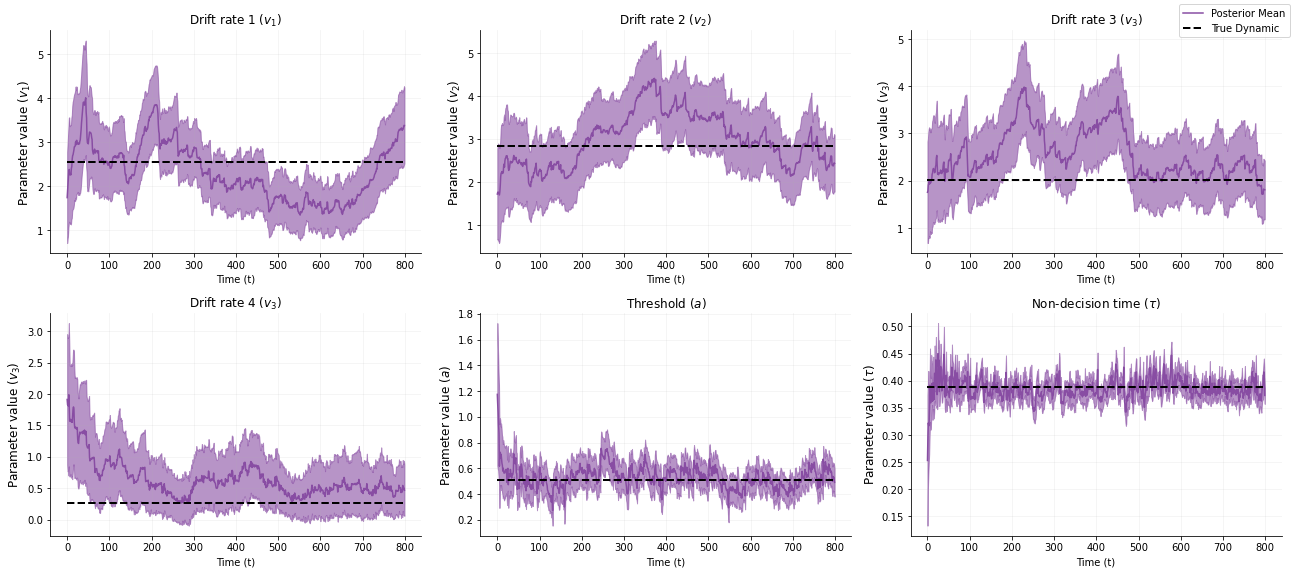

In [36]:
which = 3
dynamic_posterior = network(x_in[which:(which+1)])
ground_truths = params_t[which]
par_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
par_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_3$', r'$a$', r'$\tau$']
plot_dynamic_posteriors(dynamic_posterior, par_labels,  par_names, ground_truths)

### Compare standard deviation

In [56]:
dynamic_post_sd = np.zeros((100, 6))
stan_sd = np.zeros((100, 6))

for j in range(100):
    dynamic_posterior = network(x_in[j:(j+1)])
    dynamic_post_sd[j] = np.array(dynamic_posterior.stddev()[0, 119])
    
    v = stan_post_samples[j]['v']
    a = stan_post_samples[j]['a']
    ndt = stan_post_samples[j]['ndt']

    stan_posterior = np.c_[v, a, ndt]
    stan_sd[j] = stan_posterior.std(axis=0)

In [54]:
dynamic_post_sd.mean(axis=0)

array([0.54378812, 0.53588107, 0.51546005, 0.51225108, 0.20992537,
       0.05364887])

In [51]:
stan_sd.mean(axis=0)

array([0.16393563, 0.16122814, 0.16628025, 0.16238552, 0.02915448,
       0.00377554])